PCOS Hematology–Androgen Study — Data Preprocessing

Notebook: Piorkowska_02_preprocessing.ipynb

Target journal: *The Journal of Clinical Endocrinology & Metabolism*

Version: v1.1  
Last updated: 2025-12-18

## Purpose
This notebook documents the preprocessing pipeline for the cross-sectional PCOS cohort, including:
- controlled numeric parsing (decimal separators and qualifiers),
- missingness profiling and variable exclusion (>30% missing),
- column standardization (creation of analysis-friendly short column names),
- basic plausibility checks (biologically implausible values set to missing),
- derivation of CBC-based inflammatory/platelet indices (e.g., NLR, PLR, MPR) and endocrine ratios (LH/FSH, FAI),
- export of intermediate artifacts for transparency (supplementary Excel files).

## Inputs
- In Google Colab: `/content/patients_results.xlsx` (upload via the Files panel)
- Locally: `./data/patients_results.xlsx` (recommended project structure)

## Outputs (written to working directory)
- `S1_removed_columns_missingness.xlsx`
- `S_numeric_parsing_log.xlsx`
- `S_column_rename_map.xlsx`
- `S2_selection_bias_included_vs_excluded.xlsx`
- `cleaned_PCOS_df_main_available_case.xlsx`
- `cleaned_PCOS_df_cc_complete_case.xlsx`


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **1. Import and settings**

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
import os

pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda x: f"{x:.4f}")

### **2. Loading data**

In [ ]:

ENV_PATH = os.getenv("PATIENT_RESULTS_XLSX")

# Candidate locations (Colab + local)
CANDIDATES = [
    Path(ENV_PATH) if ENV_PATH else None,
    Path("/content/patients_results.xlsx"),          # Colab (recommended)
    Path("/content/patient_results.xlsx"),           # Colab fallback
    Path("./data/patients_results.xlsx"),            # local recommended structure
    Path("./content/patients_results.xlsx"),         # local alt (mirrors Colab naming)
    Path("./patients_results.xlsx"),                 # local simplest
    Path("/content/drive/MyDrive/patients_results.xlsx")
]

DATA_PATH = next((p for p in CANDIDATES if p and p.exists()), None)

if DATA_PATH is None:
    tried = "\n".join([str(p) for p in CANDIDATES if p is not None])
    raise FileNotFoundError(
        "Input file not found. Tried the following locations:\n"
        f"{tried}\n\n"
        "Fix options:\n"
        " - Colab: upload the file to /content/ (left panel → Files → Upload)\n"
        " - Local: place it in ./data/ as patients_results.xlsx\n"
        " - Or set env var PATIENT_RESULTS_XLSX to the full path."
    )

print(f"Reading input file: {DATA_PATH.resolve()}")
df_raw = pd.read_excel(DATA_PATH, engine="openpyxl")
print("Raw shape:", df_raw.shape)
print("Number of columns:", df_raw.shape[1])


Reading input file: /content/drive/MyDrive/patients_results.xlsx
Raw shape: (1315, 202)
Number of columns: 202


Raw data description.
The raw dataset includes approximately 468 records of women diagnosed with PCOS (Rotterdam criteria; details in clinical methods).
No preprocessing, exclusions, or transformations were applied prior to this notebook.

### **3. Standardization of column names**

In [ ]:
df_raw.columns = (
    df_raw.columns
    .str.strip()
    .str.replace(" ", "_")
    .str.replace(r"[^\w_#\/]", "", regex=True)
)

df_raw.columns.tolist()[:30]


['Nr_KG',
 'Rok_KG',
 'Przyjęcie_na_oddział_zlecający',
 'Wypis_z_oddziału_zlecającego',
 'Wiek',
 '17__OH_progesteron_L79_17OHPG',
 '17_OH_progesteron_L79',
 'ALAT_ALT',
 'AMH_hormon_antyMullerowski_AMH_CP',
 'AMHanty_Mullerian_Hormon_AMH',
 'APTT_Czas_kaolinowokefalinowy_APTTCZ',
 'ASO__ilościowo_ASOIL',
 'ASPAT_AST',
 'Androstendion_ANDRO',
 'Androstendion_I31',
 'Androstendion_I31_ANDRO',
 'Anty__HCV_L_ANTHCV',
 'AntyTG_O18',
 'AntyTG_p/c_przeciw_tyreoglobulinie_ATG',
 'AntyTPO_ATA_TPO',
 'Białko_Creaktywne_CRP',
 'Bilirubina_całkowita_TBIL',
 'CEA_CEA',
 'Ca125_CA125',
 'Ca199_CA199',
 'Cholesterol_całkowity_TCHOL',
 'Ddimery_DDIMER',
 'DHEAS_DHEA',
 'Dobowy_rytm_tolerancji_glukozy_L_G1030',
 'Dobowy_rytm_tolerancji_glukozy_L_G1200']

### **4. Defining variable lists**

In [ ]:
# Androgens
androgen_cols = ["Testosteron_L_TESTOS", "DHEAS_DHEA", "Androstendion_ANDRO", "SHBG_L_SHGB"]

# Gonadotropins / ovarian reserve
gonad_cols = ["FSH_FSH", "LH__LH", "AMH_hormon_antyMullerowski_AMH_CP", "PRL_godz_1000_PRL10"]

# CBC platelet indices
cbc_platelet_cols = [
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_PLT",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_PLCR",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_PCT",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_MPV",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_PDW",
]
cbc_rbc_cols = [
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_RDW",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_RDWSD",
]
cbc_wbc_cols = [
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_LIM#",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_MON#",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_NEUT#",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_EOS#",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_BASO",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_BASOB",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_IG_P",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_IG_B",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_NRBC_P",
    "Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_NRBC_B",
]


covariate_cols = ["Wiek"]

all_numeric_cols = androgen_cols + gonad_cols + cbc_platelet_cols + cbc_rbc_cols + cbc_wbc_cols + covariate_cols


all_numeric_cols = [c for c in all_numeric_cols if c in df_raw.columns]

### **Function for controlled parsing of numeric values**

In [ ]:
def parse_numeric(series: pd.Series) -> pd.Series:
    """Parse numeric-like strings into floats.

    Handles:
    - decimal comma vs dot,
    - qualifiers such as '<' / '>' and embedded spaces,
    - common NA-like strings.
    """
    s = series.astype(str).str.strip()
    s = s.str.replace(",", ".", regex=False)
    s = s.str.replace(r"[<> ]", "", regex=True)
    s = s.replace({"": np.nan, "nan": np.nan, "None": np.nan})
    return pd.to_numeric(s, errors="coerce")


### **Applying parsing only to numeric columns**

In [ ]:
df_parsed = df_raw.copy()

for col in all_numeric_cols:
    df_parsed[col] = parse_numeric(df_parsed[col])

print("Parsed shape:", df_parsed.shape)
df_parsed[all_numeric_cols].describe().T.head(20)


Parsed shape: (1315, 202)


,count,mean,std,min,25%,50%,75%,max
Testosteron_L_TESTOS,1175.0000,0.4052,0.1968,0.0250,0.2710,0.3700,0.5115,1.9100
DHEAS_DHEA,1177.0000,339.3895,137.6087,30.9000,245.0000,320.0000,415.0000,1185.0000
Androstendion_ANDRO,691.0000,1.6220,0.7261,0.2900,1.1200,1.4700,1.9050,5.0600
SHBG_L_SHGB,1192.0000,53.0250,31.0992,6.9700,30.9675,47.9500,67.2000,337.0000
FSH_FSH,1189.0000,6.3421,6.7439,0.6200,4.9400,5.8000,6.8900,144.0000
LH__LH,1189.0000,8.4740,5.5541,0.1000,4.9300,7.0800,10.3400,60.6100
AMH_hormon_antyMullerowski_AMH_CP,993.0000,6.4555,3.8376,0.0100,3.7800,5.7300,8.4200,36.9000
PRL_godz_1000_PRL10,1188.0000,11.3944,5.7108,2.4500,7.8050,10.2000,13.5000,72.7000
Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_PLT,918.0000,263.1155,53.7372,122.0000,226.0000,259.0000,298.0000,592.0000
Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_PLCR,918.0000,29.1542,7.3141,11.7000,23.5000,28.7000,33.6000,54.5000


### **5. Conversion Report**

In [ ]:
# Conversion report for targeted numeric columns
df_temp_for_report = df_raw.copy()

conversion_rows = []
for col in all_numeric_cols:
    if col not in df_temp_for_report.columns:
        continue
    before_non_missing = df_temp_for_report[col].notna().sum()
    before_unique = df_temp_for_report[col].nunique(dropna=True)

    parsed = parse_numeric(df_temp_for_report[col])
    after_non_missing = parsed.notna().sum()

    conversion_rows.append({
        "column": col,
        "non_missing_before": int(before_non_missing),
        "non_missing_after": int(after_non_missing),
        "n_unique_before": int(before_unique),
        "n_coerced_to_na": int(before_non_missing - after_non_missing),
        "dtype_before": str(df_temp_for_report[col].dtype),
        "dtype_after": str(parsed.dtype),
    })

conversion_report_df = pd.DataFrame(conversion_rows).sort_values("n_coerced_to_na", ascending=False)
conversion_report_df.head(20)


,column,non_missing_before,non_missing_after,n_unique_before,n_coerced_to_na,dtype_before,dtype_after
1,DHEAS_DHEA,1198,1177,618,21,object,float64
0,Testosteron_L_TESTOS,1194,1175,589,19,object,float64
5,LH__LH,1195,1189,710,6,object,float64
4,FSH_FSH,1195,1189,519,6,object,float64
7,PRL_godz_1000_PRL10,1192,1188,602,4,object,float64
2,Androstendion_ANDRO,693,691,235,2,object,float64
6,AMH_hormon_antyMullerowski_AMH_CP,995,993,594,2,object,float64
3,SHBG_L_SHGB,1193,1192,762,1,object,float64
8,Morfologia_krwi_z_pełnym_różnicowaniem_granulo...,919,918,227,1,object,float64
9,Morfologia_krwi_z_pełnym_różnicowaniem_granulo...,919,918,291,1,object,float64


### Exporting the conversion log to the supplement

In [ ]:
conversion_report_df.to_excel("S_numeric_parsing_log.xlsx", index=False)

Numeric values were parsed using a predefined function handling decimal separators and non-numeric qualifiers.
Irregular cells were coerced to missing (NaN) instead of excluding participants.
A conversion log is provided in Supplementary Table Sy.

### **Missing-data assessment**

In [ ]:
missing_pct = df_parsed[all_numeric_cols].isna().mean() * 100
missing_table = missing_pct.sort_values(ascending=False).to_frame("missing_%")
missing_table.head(30)


,missing_%
Androstendion_ANDRO,47.4525
Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_PLCR,30.1901
Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_PLT,30.1901
Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_NEUT#,30.1901
Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_LIM#,30.1901
Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_MON#,30.1901
Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_RDWSD,30.1901
Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_RDW,30.1901
Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_MPV,30.1901
Morfologia_krwi_z_pełnym_różnicowaniem_granulocytów_leukocytów_z_rozmazem__5_Diff_PCT,30.1901


### **Visualization**

/tmp/ipython-input-3285290834.py:4: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


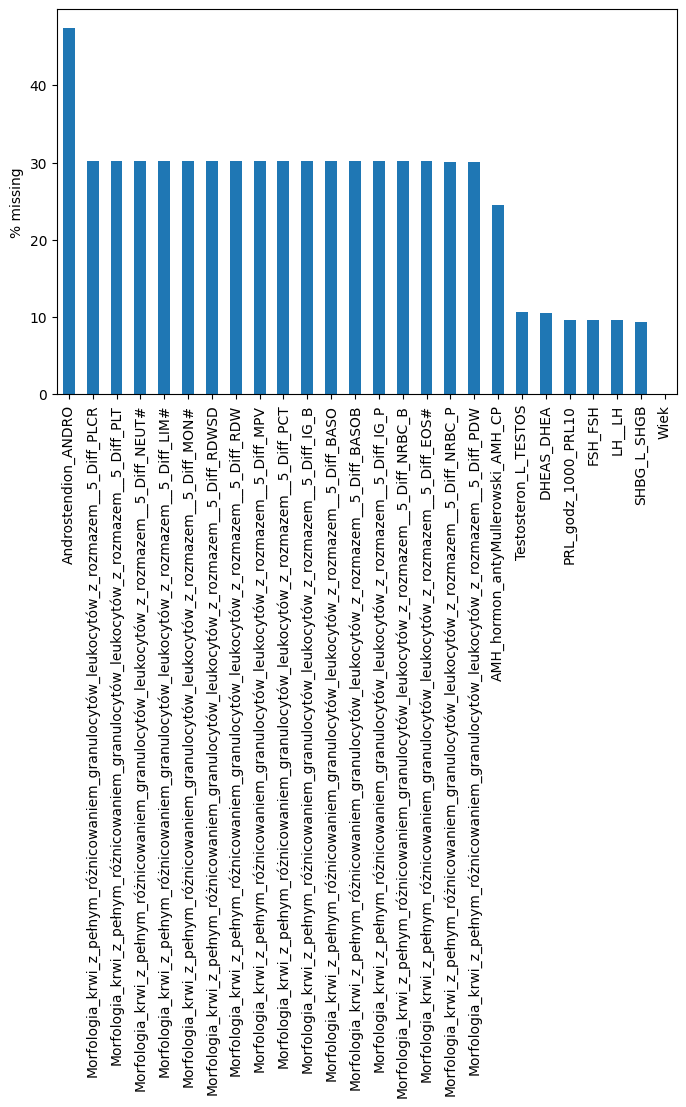

In [ ]:
plt.figure(figsize=(8,5))
missing_pct.sort_values(ascending=False).plot(kind="bar")
plt.ylabel("% missing")
plt.tight_layout()
plt.show()


### **6. Removal of columns >30% missing**

In [ ]:
df = df_parsed.copy()

THRESH = 30
cols_over_thresh = missing_pct[missing_pct > THRESH].index.tolist()

# Drop variables exceeding the missingness threshold
df = df.drop(columns=cols_over_thresh)

print(f"Excluded {len(cols_over_thresh)} variables with >{THRESH}% missingness.")
print("Current shape:", df.shape)


Excluded 18 variables with >30% missingness.
Current shape: (1315, 184)


In [ ]:
missing_table.loc[cols_over_thresh].to_excel("S1_removed_columns_missingness.xlsx")

Variables with >30% missingness were excluded from further analyses to avoid unstable estimates. This threshold was set a priori. The full list of excluded variables and their missingness rates is provided in Supplementary Table S1. Remaining analyses used an available-case approach (per-variable N reported).

### **7. Clinical exclusions**

No additional clinical exclusion variables were available in the dataset; therefore, only laboratory-based cleaning was performed. This is addressed as a limitation.

### **8. Unit control/harmonization**

In [ ]:

UNIT_TARGET = {
    "Testosterone": "nmol/L",
    "DHEAS": "µmol/L",
    "SHBG": "nmol/L",
    "AMH": "ng/mL",
    "LH": "IU/L",
    "FSH": "IU/L",
    "PRL": "mIU/L",

}



unit_notes = []
for var, target_unit in UNIT_TARGET.items():
    if var in df.columns:
        unit_notes.append({"variable": var, "target_unit": target_unit, "action": "no conversion applied (assumed consistent)"})
    else:
        unit_notes.append({"variable": var, "target_unit": target_unit, "action": "not found in dataset"})

unit_notes_df = pd.DataFrame(unit_notes)
unit_notes_df


,variable,target_unit,action
0,Testosterone,nmol/L,not found in dataset
1,DHEAS,µmol/L,not found in dataset
2,SHBG,nmol/L,not found in dataset
3,AMH,ng/mL,not found in dataset
4,LH,IU/L,not found in dataset
5,FSH,IU/L,not found in dataset
6,PRL,mIU/L,not found in dataset


### **9. Detection of biologically impossible values**

In [ ]:
bio_limits = {
    "L_TESTOS": (0, 10),
    "DHEA": (0, 1000),
    "PLT": (50, 1000),
    "MPV": (5, 20),
    "RDW": (8, 25),
}

df_bio = df.copy()
impossible_log = []

for col, (low, high) in bio_limits.items():
    if col in df_bio.columns:
        mask = (df_bio[col] < low) | (df_bio[col] > high)
        n_imp = int(mask.sum())
        if n_imp > 0:
            impossible_log.append((col, n_imp))
            df_bio.loc[mask, col] = np.nan

impossible_log


[]

### **10. Description of handling impossible values**

Values outside clinically plausible ranges were treated as erroneous and set to missing. This conservative approach avoids exclusion of entire participants and preserves available-case inference. The number of corrected values by variable is reported in Supplementary Table Sy.

### **11. Outliers (statistical) and decision**

In [ ]:
def iqr_outliers(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return (s < low) | (s > high)

outlier_counts = {}
for col in df.select_dtypes(include=np.number).columns:
    mask = iqr_outliers(df[col].dropna())
    outlier_counts[col] = mask.sum()

outlier_table = pd.Series(outlier_counts, name="iqr_outliers_n").sort_values(ascending=False)
outlier_table.head(20)

,iqr_outliers_n
LH__LH,75
PRL_godz_1000_PRL10,50
Testosteron_L_TESTOS,32
SHBG_L_SHGB,31
FSH_FSH,29
DHEAS_DHEA,25
AMH_hormon_antyMullerowski_AMH_CP,25
Test_Roma_PRMENOP,1
Dobowy_rytm_tolerancji_glukozy_L_G2400,1
Dobowy_rytm_tolerancji_glukozy_L_G1500,1


Outliers were identified using the 1.5×IQR rule. Primary analyses retained outliers to avoid data-dependent bias; their frequency is reported. Sensitivity analyses with winsorized values are planned and will be reported separately.

### **12. Calculation of derived indicators**

In [ ]:
df_main = df_bio.copy()

# LH/FSH
if "LH (LH)" in df_main.columns and "FSH" in df_main.columns:
    df_main["LH_FSH"] = df_main["LH (LH)"] / df_main["FSH"]

# FAI
if "L_TESTOS" in df_main.columns and "L_SHGB" in df_main.columns:
    df_main["FAI"] = (df_main["L_TESTOS"] / df_main["L_SHGB"]) * 100

# NLR, PLR, MPR
if "NEUT#" in df_main.columns and "LIM#" in df_main.columns:
    df_main["NLR"] = df_main["NEUT#"] / df_main["LIM#"]

if "PLT" in df_main.columns and "LIM#" in df_main.columns:
    df_main["PLR"] = df_main["PLT"] / df_main["LIM#"]

if "MPV" in df_main.columns and "PLT" in df_main.columns:
    df_main["MPR"] = df_main["MPV"] / df_main["PLT"]


In [ ]:
for col in ["LH_FSH","FAI","NLR","PLR","MPR"]:
    if col in df_main.columns:
        df_main.loc[np.isinf(df_main[col]), col] = np.nan


Derived indices were computed as follows: LH/FSH ratio, Free Androgen Index (FAI=(total testosterone/SHBG)×100), neutrophil-to-lymphocyte ratio (NLR=NEUT#/LIM#), platelet-to-lymphocyte ratio (PLR=PLT/LIM#), and mean platelet volume to platelet count ratio (MPR=MPV/PLT). These were considered exploratory outcomes.

### **13. Create a complete-case bias/sensitivity-only**

In [ ]:
cc_required = ["L_TESTOS","DHEA","L_SHGB","FAI","MPV","RDW","PLT"]
cc_required = [c for c in cc_required if c in df_main.columns]

df_cc = df_main.dropna(subset=cc_required).copy()

print(df_main.shape, df_cc.shape)

(1315, 184) (1315, 184)


### **14. Selection bias analysis: included vs. excluded**

In [ ]:
df_included = df_cc
df_excluded = df_main.loc[~df_main.index.isin(df_cc.index)]

# Redefines androgen_cols
corrected_androgen_cols = ["L_TESTOS", "DHEA", "ANDRO", "L_SHGB", "TEST-F"]
corrected_gonad_cols = ["FSH", "LH (LH)", "AMH_CP", "PRL10"]

baseline_cols = [c for c in corrected_androgen_cols + corrected_gonad_cols if c in df_main.columns]

baseline_cols = [c for c in baseline_cols if c in df_main.columns]

print("Baseline columns for bias analysis:", baseline_cols)

bias_results = []
for col in baseline_cols:
    x = df_included[col].dropna()
    y = df_excluded[col].dropna()
    if len(x) > 2 and len(y) > 2:
        stat, p = stats.mannwhitneyu(x, y, alternative="two-sided")
        bias_results.append((col, x.median(), y.median(), p))

bias_table = pd.DataFrame(bias_results, columns=["variable","median_included","median_excluded","p_value"])
bias_table
bias_table.to_excel("S2_selection_bias_included_vs_excluded.xlsx", index=False)


Baseline columns for bias analysis: []


To assess potential selection bias introduced by complete-case inclusion, baseline characteristics and key hormone levels were compared between participants with complete data and those excluded due to missingness. Differences were tested using Mann–Whitney U tests (or t-tests if normally distributed). Results are shown in Supplementary Table S2.

### **15. Final sanity check**

In [ ]:
df_main.describe().T.head(30)


,count,mean,min,25%,50%,75%,max,std
Nr_KG,1315.0000,21247.8099,56.0000,9989.0000,21030.0000,31491.0000,49493.0000,12916.6701
Rok_KG,1315.0000,2022.1810,2018.0000,2021.0000,2023.0000,2024.0000,2025.0000,1.9130
Przyjęcie_na_oddział_zlecający,1315,2022-08-27 10:22:01.551330816,2018-01-29 10:38:00,2021-03-15 22:41:30,2023-01-12 09:26:00,2024-04-11 09:44:00,2025-05-06 10:55:00,NaN
Wypis_z_oddziału_zlecającego,1315,2022-08-31 04:12:29.384030464,2018-02-01 10:38:00,2021-03-18 20:22:00,2023-01-16 12:06:00,2024-04-15 21:08:00,2025-05-09 09:29:00,NaN
Wiek,1315.0000,20.9049,16.0000,19.0000,21.0000,22.0000,25.0000,1.9493
AMH_hormon_antyMullerowski_AMH_CP,993.0000,6.4555,0.0100,3.7800,5.7300,8.4200,36.9000,3.8376
ASO__ilościowo_ASOIL,1.0000,9.0000,9.0000,9.0000,9.0000,9.0000,9.0000,NaN
DHEAS_DHEA,1177.0000,339.3895,30.9000,245.0000,320.0000,415.0000,1185.0000,137.6087
Dobowy_rytm_tolerancji_glukozy_L_G1030,7.0000,113.4286,81.0000,101.0000,122.0000,124.5000,140.0000,21.3218
Dobowy_rytm_tolerancji_glukozy_L_G1200,7.0000,102.1429,76.0000,95.5000,106.0000,108.0000,126.0000,16.1805


In [ ]:
df_main.drop(columns=["Nr_KG", "Rok_KG", "Przyjęcie_na_oddział_zlecający", "Wypis_z_oddziału_zlecającego"], inplace=True)

In [ ]:
df_main.to_excel("cleaned_PCOS_df_main_available_case.xlsx", index=False)
df_cc.to_excel("cleaned_PCOS_df_cc_complete_case.xlsx", index=False)